A demonstration to calculate the Potential Energy Anomaly and demonstrate regional masking with MaskMaker


### Relevant imports and filepath configuration

In [1]:
import os
os.chdir('../../../../')
import coast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors  # colormap fiddling
import xarray as xr

In [2]:
# set some paths
root = "./"
dn_files = root + "./example_files/"
fn_nemo_grid_t_dat = dn_files + "nemo_data_T_grid_Aug2015.nc"
fn_nemo_dom = dn_files + "coast_example_nemo_domain.nc"
config_t = root + "./config/example_nemo_grid_t.json"

### Loading data

In [3]:
# Create a Gridded object and load in the data:
nemo = coast.Gridded(fn_nemo_grid_t_dat, fn_nemo_dom, config=config_t)

### Calculates Potential Energy Anomaly

The density and depth averaged density can be supplied within gridded_t as `density` and
`density_bar` DataArrays, respectively. If they are not supplied they will be calculated.
`density_bar` is calcuated using depth averages of temperature and salinity.



In [4]:
# Compute a vertical max to exclude depths below 200m
Zd_mask, kmax, Ikmax = nemo.calculate_vertical_mask(200.)

# Initiate a stratification diagnostics object
strat = coast.GriddedStratification(nemo)

In [5]:
# calculate PEA for unmasked depths
strat.calc_pea(nemo, Zd_mask)

## make a plot

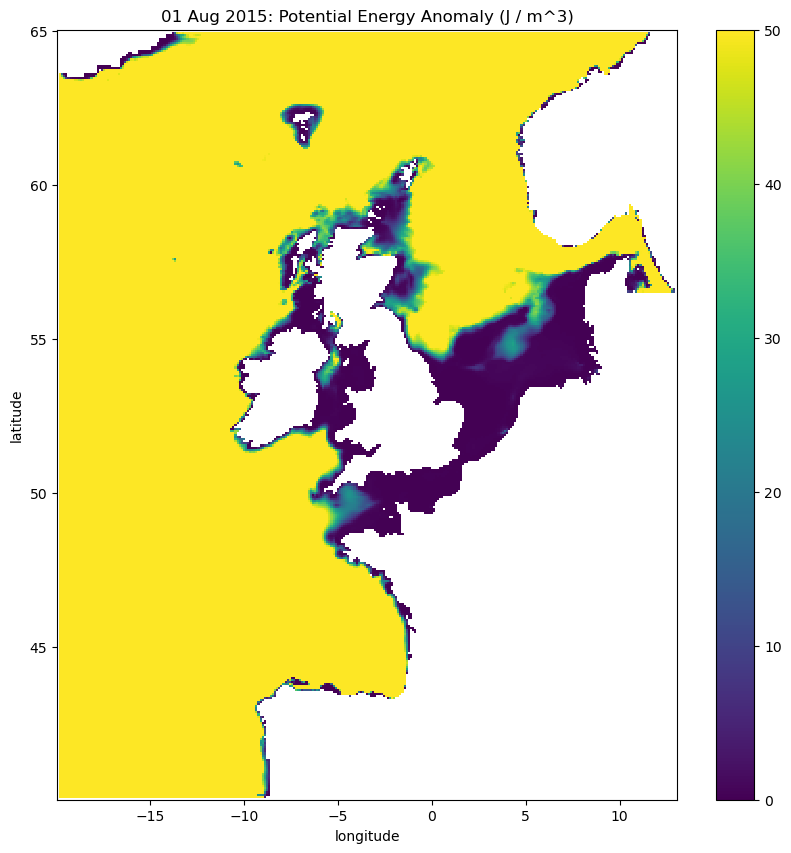

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot: title={'center': '01 Aug 2015: Potential Energy Anomaly (J / m^3)'}, xlabel='longitude', ylabel='latitude'>)

In [6]:
strat.quick_plot('PEA')

In [7]:
strat.dataset

<xarray.Dataset>
Dimensions:    (t_dim: 7, y_dim: 375, x_dim: 297)
Coordinates:
    time       (t_dim) datetime64[ns] 2015-08-01T12:00:00 ... 2015-08-07T12:0...
    latitude   (y_dim, x_dim) float32 40.07 40.07 40.07 40.07 ... 65.0 65.0 65.0
    longitude  (y_dim, x_dim) float32 -19.89 -19.78 -19.67 ... 12.78 12.89 13.0
Dimensions without coordinates: t_dim, y_dim, x_dim
Data variables:
    PEA        (t_dim, y_dim, x_dim) float64 nan nan nan nan ... nan nan nan nan

# Use MaskMaker to define regions and do regional analysis

MaskMaker can build a stack of boolean masks in an xarray dataset for regional analysis. For the NWS we can use some built-in regions.  

In [8]:
mm = coast.MaskMaker()

# Define Regional Masks
regional_masks = []

# Define convenient aliases based on nemo data
lon = nemo.dataset.longitude.values
lat = nemo.dataset.latitude.values
bathy = nemo.dataset.bathymetry.values

# Add regional mask for whole domain
regional_masks.append(np.ones(lon.shape))

# Add regional mask for English Channel
regional_masks.append(mm.region_def_nws_north_sea(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_outer_shelf(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_norwegian_trench(lon, lat, bathy))
regional_masks.append(mm.region_def_nws_english_channel(lon, lat, bathy))
regional_masks.append(mm.region_def_south_north_sea(lon, lat, bathy))
regional_masks.append(mm.region_def_off_shelf(lon, lat, bathy))
regional_masks.append(mm.region_def_irish_sea(lon, lat, bathy))
regional_masks.append(mm.region_def_kattegat(lon, lat, bathy))

region_names = ["whole domain", "north sea", "outer shelf", "norwegian trench",
                "english_channel", "southern north sea", "off shelf",
                "irish sea", "kattegat",]

Convert this list of masks into a dataset

In [9]:
mask_list = mm.make_mask_dataset(lon, lat, regional_masks, region_names)

In [10]:
mask_list

<xarray.Dataset>
Dimensions:       (y_dim: 375, x_dim: 297, dim_mask: 9)
Coordinates:
    longitude     (y_dim, x_dim) float32 -19.89 -19.78 -19.67 ... 12.89 13.0
    latitude      (y_dim, x_dim) float32 40.07 40.07 40.07 ... 65.0 65.0 65.0
    region_names  (dim_mask) <U18 'whole domain' 'north sea' ... 'kattegat'
Dimensions without coordinates: y_dim, x_dim, dim_mask
Data variables:
    mask          (dim_mask, y_dim, x_dim) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0

Inspect the mask with a `quick_plot()` method. 

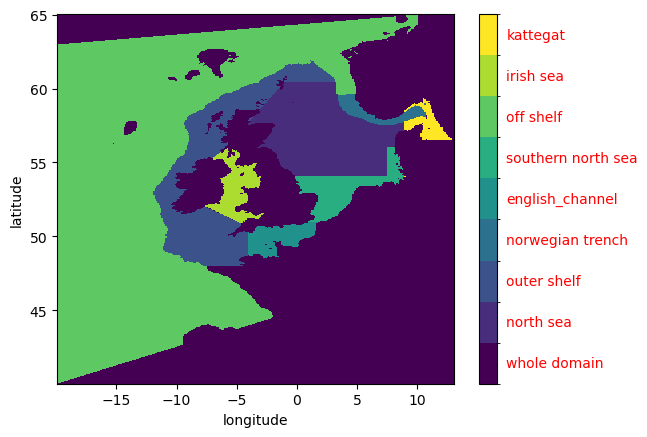

In [11]:
mm.quick_plot(mask_list)


NB overlapping regions are not given special treatment, the layers are blindly superimposed on each other. E.g. as demonstrated with "Norwegian Trench" and "off shelf", or "whole domain" and any other region.

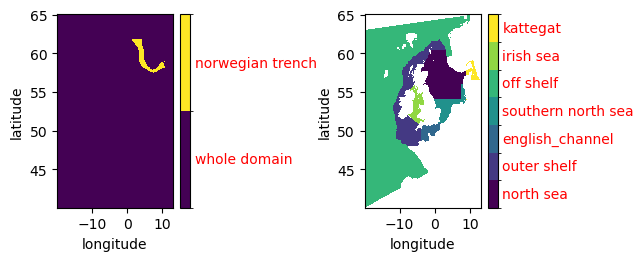

In [12]:

plt.subplot(2,2,1)
mm.quick_plot(mask_list.sel(dim_mask=[0,3]))

plt.subplot(2,2,2)
mm.quick_plot(mask_list.sel(dim_mask=[1,2,4,5,6,7,8]))



plt.tight_layout()

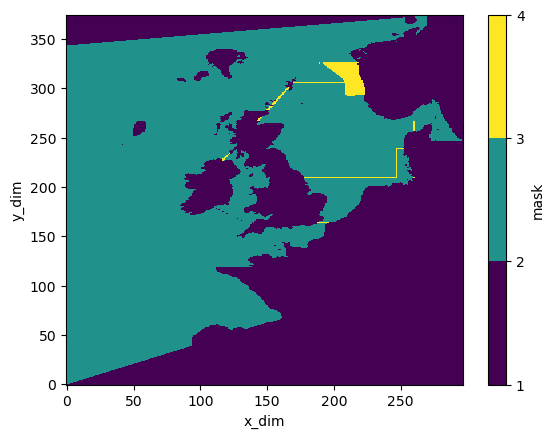

In [13]:
# Show overlap
mask_list.mask.sum(dim='dim_mask').plot( levels=(1,2,3,4))

# Save if required
#plt.savefig('tmp.png')

# Regional analysis

Average stratification object over regions using the mask

In [14]:
mask_means = (strat.dataset*mask_list.mask).mean(dim='x_dim').mean(dim='y_dim')

In [15]:
mask_means

<xarray.Dataset>
Dimensions:       (t_dim: 7, dim_mask: 9)
Coordinates:
    time          (t_dim) datetime64[ns] 2015-08-01T12:00:00 ... 2015-08-07T1...
    region_names  (dim_mask) <U18 'whole domain' 'north sea' ... 'kattegat'
Dimensions without coordinates: t_dim, dim_mask
Data variables:
    PEA           (t_dim, dim_mask) float64 130.9 4.603 7.291 ... 0.2 1.515

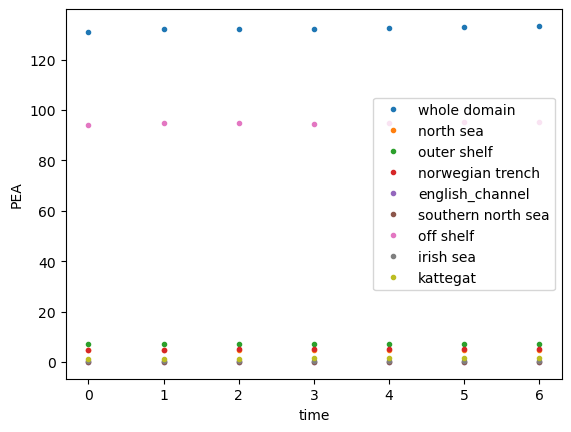

In [16]:
# Plot timeseries per region

for count_region in range(mask_means.dims['dim_mask']):
    
    plt.plot( 
        mask_means.PEA.isel(dim_mask=count_region),
        label=mask_means.region_names[count_region].values,
        marker=".", linestyle='none')

plt.xlabel('time'); plt.ylabel('PEA')
plt.legend()